In [4]:
from pygrounds.utils.warehouse.ds_warehouse import DSWarehouse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dsw = DSWarehouse()

In [16]:
counties = pd.read_csv('/Users/rwolf/Desktop/county_adjacency.txt', sep='\t', encoding='cp1252')

In [17]:
counties.columns = ['county', 'geocode', 'trash1', 'trash2']
counties = counties.loc[(~counties.county.isnull()) & (~counties.geocode.isnull()) , ['county', 'geocode']]

county     3232
geocode    3233
dtype: int64

In [22]:
ca_counties = counties.loc[counties['county'].str.contains(', CA')]

### Get Disease info

In [6]:
excel_path = '/Users/rwolf/Downloads/County_Table_Chronic_Conditions_Prevalence_by_Age_2017.xlsx'
disease_old = pd.read_excel(excel_path, sheet_name='Beneficiaries 65 Years and Over', skiprows=5, na_values=['* '])
disease_young = pd.read_excel(excel_path, sheet_name='Beneficiaries Less than 65 Year', skiprows=5, na_values=['* '])

In [8]:
disease_young.columns

Index(['State', 'County', 'State/County FIPS Code', 'Alcohol Abuse',
       'Alzheimer's Disease/Dementia', 'Arthritis', 'Asthma',
       'Atrial Fibrillation', 'Autism Spectrum Disorders', 'Cancer',
       'Chronic Kidney Disease', 'COPD', 'Depression ', 'Diabetes',
       'Drug Abuse/Substance Abuse', 'HIV/AIDS', 'Heart Failure',
       'Hepatitis (Chronic Viral B & C)', 'Hyperlipidemia', 'Hypertension',
       'Ischemic Heart Disease', 'Osteoporosis',
       'Schizophrenia/Other Psychotic Disorders', 'Stroke'],
      dtype='object')

In [9]:
disease_young.head()

,State,County,State/County FIPS Code,Alcohol Abuse,Alzheimer's Disease/Dementia,Arthritis,Asthma,Atrial Fibrillation,Autism Spectrum Disorders,Cancer,...,Drug Abuse/Substance Abuse,HIV/AIDS,Heart Failure,Hepatitis (Chronic Viral B & C),Hyperlipidemia,Hypertension,Ischemic Heart Disease,Osteoporosis,Schizophrenia/Other Psychotic Disorders,Stroke
0,National,,,6.5858,4.3743,27.1315,7.8557,2.2972,1.3647,2.9863,...,12.0901,1.6203,10.3439,2.4773,28.4056,42.5617,16.8898,2.4552,10.1428,2.7288
1,Alabama,,,5.3454,3.3975,32.1129,6.6789,2.0159,0.5968,3.0063,...,12.3682,1.1868,11.4412,1.6506,31.0783,51.9059,18.3364,2.0297,7.6647,2.8649
2,Alabama,Autauga,01001,5.7602,3.1161,28.7063,4.9103,1.8886,NaN,3.0217,...,8.9707,NaN,11.1426,1.4164,32.6723,47.7809,16.9972,3.1161,7.7432,2.5496
3,Alabama,Baldwin,01003,4.7818,3.7657,34.2499,6.0072,2.4507,NaN,3.5565,...,14.3156,0.8368,9.8027,1.8231,25.6426,43.9928,20.2032,2.3013,5.7980,1.9426
4,Alabama,Barbour,01005,6.5825,3.1560,29.7565,7.9351,1.7133,NaN,3.0658,...,8.4761,NaN,9.5582,NaN,33.9946,55.1849,14.9684,1.7133,9.0171,2.7051


In [85]:
odds_dict = dict(
    asthma=5.4,
    afib=5.4,
    cancer=10,
    copd=5.4,
    chronic_kidney=6,
    diabetes=2.85,
    hiv_aids=20,
    heart_failure=21.4,
    hepatitis=5,
    hyperlipidemia=3.05,
    hypertension=3.05,
    ischemic_heart_disease=21.4,
    stroke=3
)

In [86]:
cols = ['State', 'County', 'State/County FIPS Code',
       'Asthma',
       'Atrial Fibrillation', 'Cancer',
       'COPD', 'Chronic Kidney Disease', 'Diabetes',
       'HIV/AIDS', 'Heart Failure',
       'Hepatitis (Chronic Viral B & C)', 'Hyperlipidemia', 'Hypertension',
       'Ischemic Heart Disease',
       'Stroke']
disease_young = disease_young[cols]
disease_old = disease_old[cols]
disease_young.columns = ['state', 'county', 'fips'] + list(odds_dict.keys())
disease_old.columns = ['state', 'county', 'fips'] + list(odds_dict.keys())

In [87]:
disease_young = disease_young.loc[disease_young['state'] == 'California ']
disease_old = disease_old.loc[disease_old['state'] == 'California ']

In [88]:
# Fill NA with state averages
disease_young = disease_young.fillna(dict(disease_young.iloc[0]))
disease_old = disease_old.fillna(dict(disease_young.iloc[0]))

In [97]:
disease_young['disease_risk'] = np.dot(disease_young[list(odds_dict.keys())], np.log(list(odds_dict.values())))
disease_old['disease_risk'] = np.dot(disease_old[list(odds_dict.keys())], np.log(list(odds_dict.values())))

In [98]:
disease_young['age_risk'] = np.log(1.14) * 40
disease_old['age_risk'] = np.log(1.14) * 70

In [100]:
disease_young['total_risk'] = disease_young['age_risk'] + disease_young['disease_risk']
disease_old['total_risk'] = disease_old['age_risk'] + disease_old['disease_risk']
disease_young['age'] = 'under_65'
disease_old['age'] = 'over_65'

In [120]:
disease = pd.concat([disease_young, disease_old])

In [121]:
disease[disease['county'] == ' '] = 'state_average'

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text xticklabel objects>)

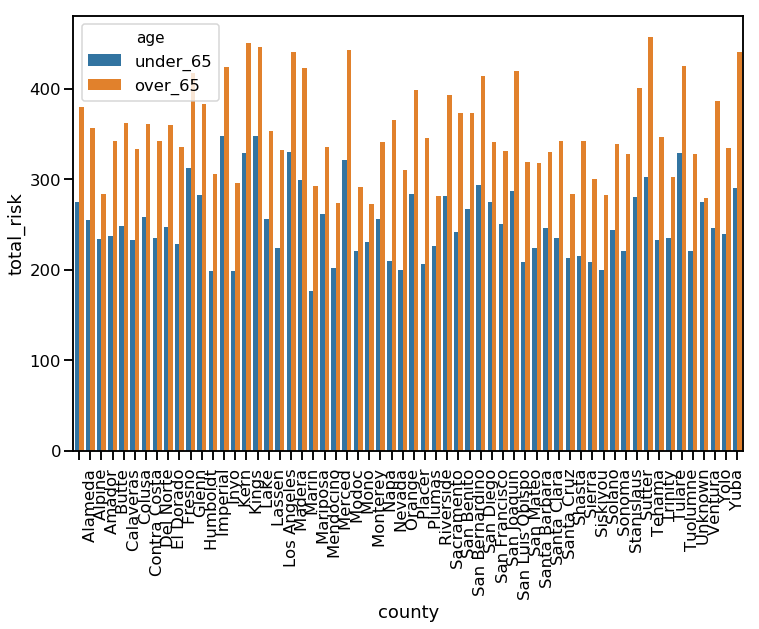

In [122]:
sns.set_context('talk')
plt.figure(figsize=(12, 8))
sns.barplot(data=disease, x='county', y='total_risk', hue='age')
plt.xticks(rotation=90)

### Downloading From CMS if Necessary

In [1]:
import urllib
import zipfile
import io

In [2]:
tmp_file = urllib.request.urlretrieve('https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Chronic-Conditions/Downloads/CC_Prev_State_County_Age.zip')[0]

In [5]:
with open(tmp_file, 'rb') as f:
    zip_data = zipfile.ZipFile(f)
    excel_bytes = io.BytesIO(zip_data.read('County_Table_Chronic_Conditions_Prevalence_by_Age_2017.xlsx'))

    disease_old = pd.read_excel(excel_bytes, sheet_name='Beneficiaries 65 Years and Over', skiprows=5, na_values=['* '])
    disease_young = pd.read_excel(excel_bytes, sheet_name='Beneficiaries Less than 65 Year', skiprows=5, na_values=['* '])
    
disease_old.head()   

,State,County,State/County FIPS Code,Prevalence (%),Prevalence (%).1,Prevalence (%).2,Prevalence (%).3,Prevalence (%).4,Prevalence (%).5,Prevalence (%).6,...,Prevalence (%).11,Prevalence (%).12,Prevalence (%).13,Prevalence (%).14,Prevalence (%).15,Prevalence (%).16,Prevalence (%).17,Prevalence (%).18,Prevalence (%).19,Prevalence (%).20
0,National,,,1.7725,12.0640,34.2176,4.6316,9.5033,0.0233,9.2201,...,1.7320,0.1222,14.5429,0.5145,42.9702,59.8793,28.7996,7.0981,1.7199,3.9787
1,Alabama,,,1.7334,13.9121,40.3171,4.6723,9.5177,0.0109,9.1872,...,2.3183,0.0776,17.2593,0.3512,48.6242,69.1113,32.8638,7.0105,1.9930,4.6672
2,Alabama,Autauga,01001,1.5731,12.3911,36.6167,4.4530,10.3098,NaN,9.8742,...,1.7425,NaN,17.0620,0.2904,53.1462,67.7880,34.9952,7.2604,1.8393,4.4530
3,Alabama,Baldwin,01003,1.7270,12.0132,38.1982,4.7225,10.5444,NaN,9.3159,...,2.4213,0.0623,13.3262,0.3160,46.8198,62.7676,33.6004,6.8589,1.5489,4.1617
4,Alabama,Barbour,01005,4.0377,14.6030,40.4441,4.6097,8.8156,NaN,10.2961,...,3.6676,NaN,15.3432,NaN,51.2450,71.7362,30.6864,5.8210,2.8264,5.2826
